# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [6]:
col = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range', 'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA','sample','Rating']
data.columns = col

In [7]:
data.info(100000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine_Style        38410 non-null object
Ranking              50000 non-null float64
Price_Range          32639 non-null object
Number_of_Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
data.head(50000)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


# Cleaning and Prepping Data

**Проверяем столбец с Restaurant_id (идентификационный номер ресторана / сети ресторанов)**

In [9]:
data.Restaurant_id.value_counts()
# пропусков нет, все ок

print(data.Restaurant_id.describe())
# по условию - в одному id  могут быть прикреплены несколько ресторанов одной сети,
# поэтому уникальных значений меньше чем записей

data.Restaurant_id = [i[3:] for i in data.Restaurant_id]
data.Restaurant_id = [int(i) for i in data.Restaurant_id]

print(' ')
print(len(data.Restaurant_id))
print(type(data.Restaurant_id[1]))

# превратили столбец в численное выражение

data.Restaurant_id

count      50000
unique     13094
top       id_633
freq          19
Name: Restaurant_id, dtype: object
 
50000
<class 'numpy.int64'>


0           0
1           1
2           2
3           3
4           4
         ... 
49995     499
49996    6340
49997    1649
49998     640
49999    4824
Name: Restaurant_id, Length: 50000, dtype: int64

**Проверяем столбец с City (город, в котором находится ресторан)**

In [10]:
data.City.value_counts()
# пропусков нет, города не повторяются, проблем с ракладкой или регистром нет, все ок

print(data.City.describe())

A = list(data.City.value_counts().keys())
B = range(0, len(A))
dict_city = dict(zip(A, B))
# словарь со значениями городов

data['City_ind'] = data['City'].replace(A, B)

print(' ')
print(len(data.City_ind))
print(type(data.City_ind[1]))

# аномалий нет + мы заменили города на числовые индефикаторы


count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object
 
50000
<class 'numpy.int64'>


**Добавим столбец Residents (кол-во жителей в каждом городе)**

In [11]:
B = [8961989, 2148271, 3266126, 1636762, 3769495, 1397852, 4110000, 1324277, 506654, 1888776, 860124,
     179277, 1899160, 1471508, 481181, 975904, 1752286, 1790658, 1173179, 794128, 664046, 513210, 424008,
     237591, 201818, 779115, 693491, 643272, 432862, 626108, 295504]
dict_res = dict(zip(A, B))
# словарь со кол-вом жителей

data['Residents'] = data['City'].replace(A, B)

print(len(data.Residents))
print(type(data.Residents[1]))

50000
<class 'numpy.int64'>


**Добавим столбец Country (страна)**

In [12]:
data['Country'] = data.City
data['Country'] = data['Country'].replace('London', 'GreatBritain')
data['Country'] = data['Country'].replace('Paris', 'France')
data['Country'] = data['Country'].replace('Madrid', 'Spain')
data['Country'] = data['Country'].replace('Barcelona', 'Spain')
data['Country'] = data['Country'].replace('Berlin', 'Germany')
data['Country'] = data['Country'].replace('Milan', 'Italy')
data['Country'] = data['Country'].replace('Rome', 'Italy')
data['Country'] = data['Country'].replace('Prague', 'CzechRepublic')
data['Country'] = data['Country'].replace('Lisbon', 'Portugal')
data['Country'] = data['Country'].replace('Vienna', 'Austria')
data['Country'] = data['Country'].replace('Amsterdam', 'Netherlands')
data['Country'] = data['Country'].replace('Brussels', 'Belgium')
data['Country'] = data['Country'].replace('Hamburg', 'Germany')
data['Country'] = data['Country'].replace('Munich', 'Germany')
data['Country'] = data['Country'].replace('Lyon', 'France')
data['Country'] = data['Country'].replace('Stockholm', 'Sweden')
data['Country'] = data['Country'].replace('Budapest', 'Hungary')
data['Country'] = data['Country'].replace('Warsaw', 'Poland')
data['Country'] = data['Country'].replace('Dublin', 'Irland')
data['Country'] = data['Country'].replace('Copenhagen', 'Denmark')
data['Country'] = data['Country'].replace('Athens', 'Greece')
data['Country'] = data['Country'].replace('Edinburgh', 'Scotland')
data['Country'] = data['Country'].replace('Zurich', 'Switzeland')
data['Country'] = data['Country'].replace('Oporto', 'Portugal')
data['Country'] = data['Country'].replace('Geneva', 'Switzeland')
data['Country'] = data['Country'].replace('Krakow', 'Poland')
data['Country'] = data['Country'].replace('Oslo', 'Norway')
data['Country'] = data['Country'].replace('Helsinki', 'Finland')
data['Country'] = data['Country'].replace('Bratislava', 'Slovakia')
data['Country'] = data['Country'].replace('Luxembourg', 'Luxembourg')
data['Country'] = data['Country'].replace('Ljubljana', 'Slovenia')

A = list(data.Country.value_counts().keys())
B = range(0, len(A))
dict_country = dict(zip(A, B))
# словарь со значениями стран


data['Country_ind'] = data['Country'].replace(A, B)

print(len(data.Country_ind))
print(type(data.Country_ind[1]))

50000
<class 'numpy.int64'>


**Добавим столбик с отношением кол-ва отзывов к населению (как часто пишут их)**

In [13]:
data['Rew_of'] = data['Number_of_Reviews']/data['Residents']
data['Rew_of'] = data['Rew_of'].fillna(0)



print(len(data.Rew_of))
print(type(data.Rew_of[1]))

50000
<class 'numpy.float64'>


**Проверяем столбец с Cuisine_Style (кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане)**

In [14]:
data['Cuisine_Style'] = data['Cuisine_Style'].fillna('""No_info"')
# заменяем пропуски

new = pd.DataFrame(data.Cuisine_Style.dropna())
a = list(new.Cuisine_Style)
b = list()

def l(x):
    i = 0
    for g in x:
        f = x[i].split(',')
        v = 0
        for g in f:
            h = f[v][2:-1].replace("'", '')
            v = +1
            b.append(h)
        i += 1
        
l(a)

from collections import Counter

coun=Counter(b)
coun=dict(coun)
coun=pd.DataFrame({'count':coun}, columns=['count'])
a=coun['count'].mean()

b=list(coun.query('count > @a').index)
b

#оставляем только самые популярные кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in b:
    data[item] = data['Cuisine_Style'].apply(find_item)

data['Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: len(x))

len(data['Cuisine_Style'])
# пропуски заменены, строки преобразованы в столбцы

50000

**Проверяем столбец с Price_Range (диапазон цен в ресторане)**

In [15]:
print(data.Price_Range.describe())

data['Price_Range'] = data['Price_Range'].replace('$', 1)
data['Price_Range'] = data['Price_Range'].replace('$$ - $$$', 2)
data['Price_Range'] = data['Price_Range'].replace('$$$$', 3)

a = data['Price_Range'].mean()
a = int(a)
data['Price_Range'] = data['Price_Range'].fillna(a)

print('')
print(len(data.Price_Range))
print(type(data.Price_Range[1]))
# заменили буквенные индефикаторы на численные

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price_Range, dtype: object

50000
<class 'numpy.float64'>


**Проверяем столбец с Reviews (данные о двух отзывах, которые отображаются на сайте ресторана)**

In [16]:
print(data.Reviews.describe())

from datetime import datetime, date, time
data['Reviews'] = data.Reviews.replace("[[], []]", 'No_info')
# заменяем пропуски

data['Last_rew'] = data['Reviews']

data['Last_rew']=data['Last_rew'].str[-27:-17]

now = datetime.now()

#base['Last_rew'][base.Last_rew.str.contains("]")]=now
data['Last_rew'][data.Last_rew.str.contains("]")==True] = now
data['Last_rew'] = data['Last_rew'].fillna(now)

# приравниваем строки без даты к сегодня

data['Last_rew'] = [pd.to_datetime(i) for i in data.Last_rew]

# добавляем сколько прошло времени с момента последнего отзыва

data['Last_rew_data'] = data['Last_rew']-now
data['Last_rew_data'] = [i.total_seconds() for i in data.Last_rew_data]
data['Last_rew_data'] = data['Last_rew_data']
data['Last_rew_data'] = data['Last_rew_data'].fillna(0)



print('')
print(len(data.Last_rew_data))
print(type(data.Last_rew_data[1]))

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



50000
<class 'numpy.float64'>


**Проверяем столбец с Number_of_Reviews (количество отзывов о ресторане)**

In [17]:
from datetime import datetime, date, time

m=data['Number_of_Reviews'].mean()

print(data['Number_of_Reviews'].describe())
# отрицательных чисел нет

data['Number_of_Reviews'].value_counts()
# но есть пропуски, нужно проверить, что где есть пропуски - там действительно нет отзывов

data['Number_of_Reviews'] = data['Number_of_Reviews'].fillna('No_info')
# меняем пропуски на Not_info

a = data.query('Reviews == "No_info" & Number_of_Reviews == "No_info"')
b = list(a.index)
data['Number_of_Reviews'][b] = 0
# где нет значения кол-ва отзывов и превью отзывов - ставим 0

len(data['Number_of_Reviews'])
# заменили предполагаемые пропуски, в некоторые смогли подставить значения. С 2,5+ тысяч снизили пропуски до 900+

data['Number_of_Reviews'] = data['Price_Range'].replace('No_info', m)

# пропуски, которые не смогли заполнить, заполняем средним значением

#data.Number_of_Reviews = [float(i) for i in data.Number_of_Reviews]

print('')
print(len(data.Number_of_Reviews))
print(type(data.Number_of_Reviews[1]))

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64

50000
<class 'numpy.float64'>


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


**Проверяем м столбец с URL_TA (URL страницы ресторана на TripAdvosor)**

In [18]:
print(data['URL_TA'].describe())

data['URL_TA'].value_counts()

# очень странно, что сслылки повторяются
# посмотрим что с ними на примере одного ресторана
data.query(
    'URL_TA == "/Restaurant_Review-g187514-d697406-Reviews-Al_Mounia-Madrid.html"')
# совпадают 8 столбцов из 10 основных

# удалим дубликаты по стобцам сайт, ID на сайте, город, кол-во отзывов, кухни и средний чек
#data = data.drop_duplicates(
#    subset=['City', 'Reviews', 'URL_TA', 'ID_TA', 'Cuisine_Style', 'Price_Range'])

data['URL_TA'].value_counts()

# дубликаты удалены

print('')
print(len(data.URL_TA))
print(type(data.URL_TA[1]))

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d9802625-Reviews-La...
freq                                                      2
Name: URL_TA, dtype: object

50000
<class 'str'>


**проверяем м столбец с ID_TA (идентификатор ресторана в базе данных TripAdvisor)**

In [19]:
print(data['ID_TA'].describe())

data['ID_TA']=data['ID_TA'].str[1:]
data.ID_TA = [float(i) for i in data.ID_TA]

# так как в предыдущем шаге мы удалили все дубликаты, то в этом у нас все ок

print('')
print(len(data.ID_TA))
print(type(data.ID_TA[1]))

count         50000
unique        49963
top       d11921719
freq              2
Name: ID_TA, dtype: object

50000
<class 'numpy.float64'>


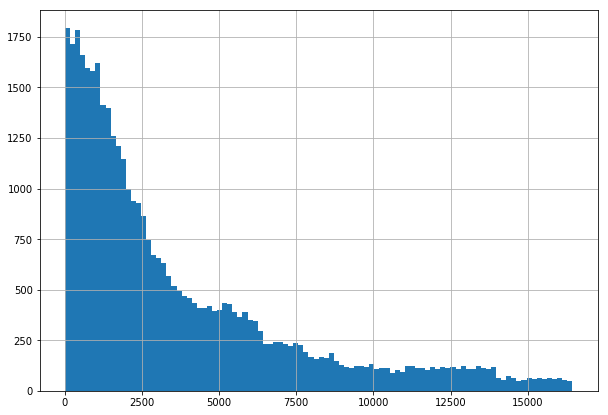

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

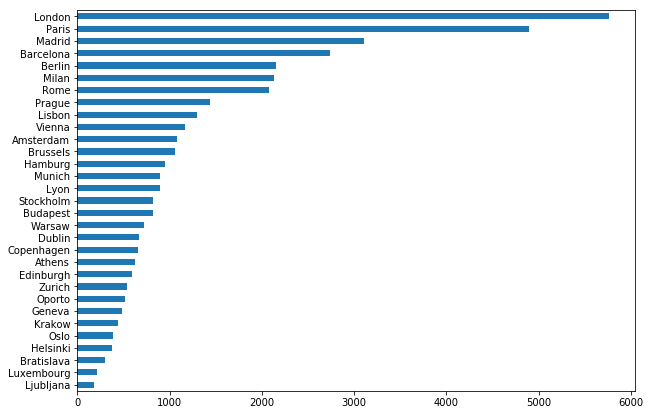

In [21]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

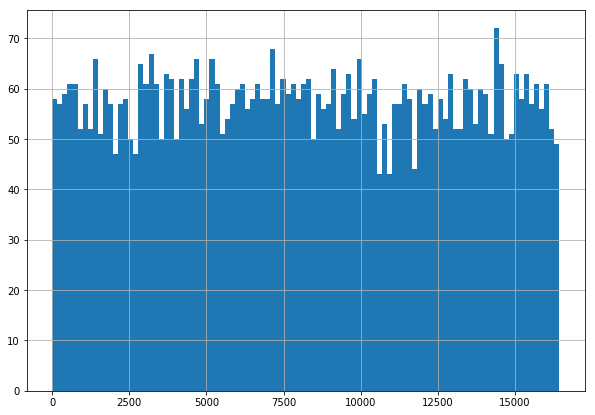

In [22]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

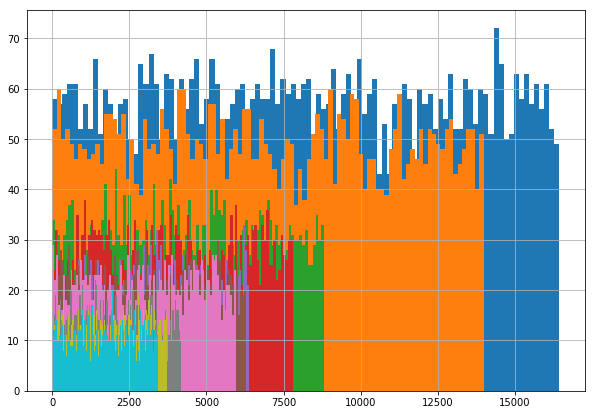

In [23]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

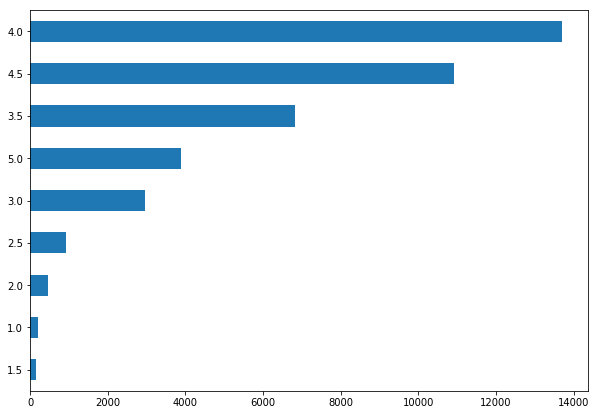

In [24]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

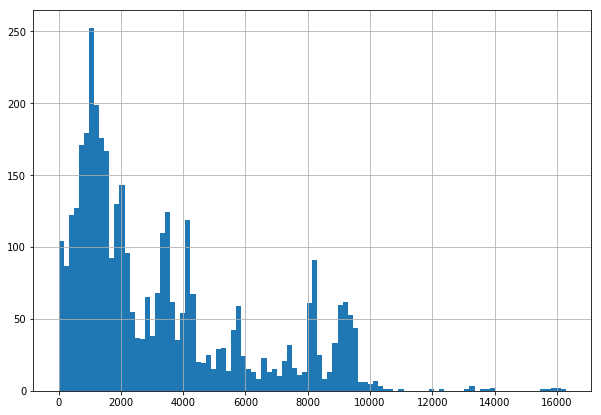

In [25]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

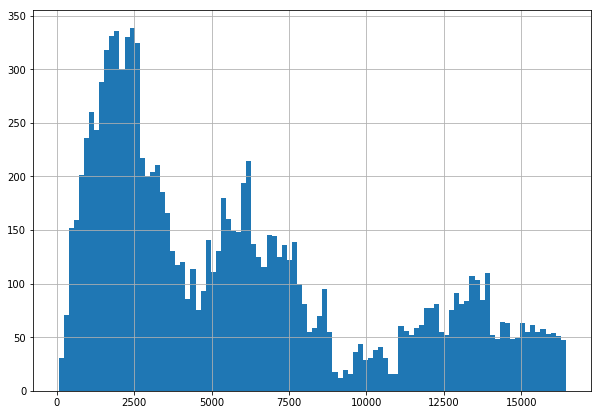

In [26]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

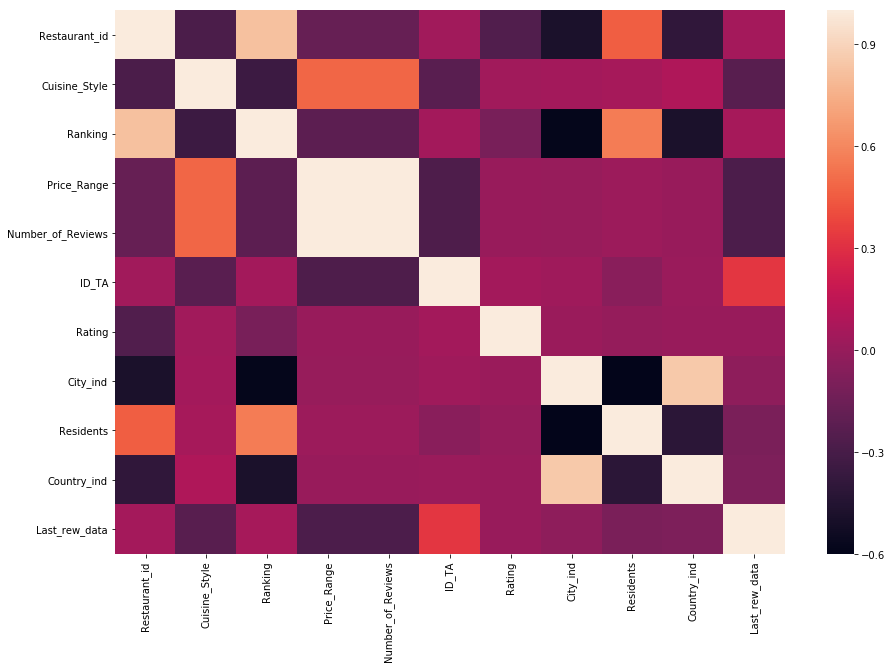

In [27]:
data1=data
col= ['Restaurant_id', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'ID_TA', 'sample', 'Rating', 'City_ind',
       'Residents', 'Country_ind','Last_rew_data']

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data1[col].drop(['sample'], axis=1).corr(),)

# Data Preprocessing

In [28]:
data = data.drop('URL_TA', axis=1)
data = data.drop('Reviews', axis=1)
data = data.drop('Last_rew', axis=1)
data = data.drop('City', axis=1)
data = data.drop('Country', axis=1)
data = data.drop('Restaurant_id', axis=1)
data = data.drop('Cuisine_Style', axis=1)

In [29]:
pd.options.display.max_info_columns 
data.info(verbose=True, max_cols=False, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
Ranking                50000 non-null float64
Price_Range            50000 non-null float64
Number_of_Reviews      50000 non-null float64
ID_TA                  50000 non-null float64
sample                 50000 non-null int64
Rating                 50000 non-null float64
City_ind               50000 non-null int64
Residents              50000 non-null int64
Country_ind            50000 non-null int64
Rew_of                 50000 non-null float64
American               50000 non-null int64
Asian                  50000 non-null int64
Bar                    50000 non-null int64
British                50000 non-null int64
Cafe                   50000 non-null int64
Chinese                50000 non-null int64
European               50000 non-null int64
Fast Food              50000 non-null int64
French                 50000 non-null int64
Indian                 50000 non-null int64

In [30]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [31]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [32]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 32), (40000, 32), (40000, 31), (32000, 31), (8000, 31))

# Model 
Сам ML

In [33]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [34]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [35]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [36]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20565187499999998


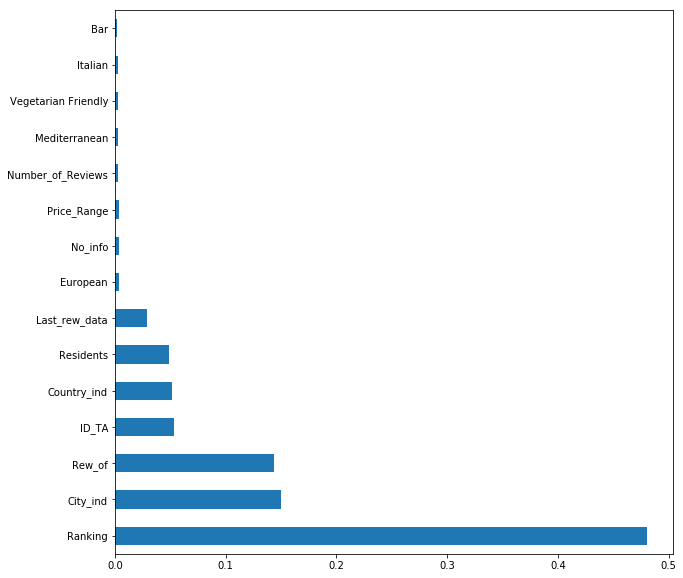

In [37]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [38]:
test_data.sample(10)
test_data = test_data.drop(['Rating'], axis=1)

In [39]:
len(test_data)

10000

In [40]:
len(sample_submission)

10000

In [41]:
predict_submission = model.predict(test_data)
len(predict_submission)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


10000

In [42]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.075
1,id_1,4.305
2,id_2,4.320
3,id_3,4.390
4,id_4,4.380
5,id_5,4.470
6,id_6,2.095
7,id_7,2.565
8,id_8,4.055
9,id_9,4.500
